In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import wandb

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, ModuleList
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import global_mean_pool

import functions as f

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
os.environ['WANDB_NOTEBOOK_NAME']="MPNN.ipynb"

- MPNNLayer class defines a single message passing layer, inheriting from torch_geometric.nn.MessagePassing. It applies a linear transformation to the input node features and then performs message passing.
- forward method of MPNNLayer adds self-loops to the adjacency matrix, linearly transforms the input node features, and then starts propagating messages using the propagate method.
- message method of MPNNLayer normalizes node features and multiplies them with the corresponding adjacency weights.
- update method of MPNNLayer returns the new node embeddings after aggregation.
- MPNN class serves as a container for multiple MPNNLayer instances, similar to the GCN class. It iterates over the layers, applies them sequentially, and then applies a final MLP for prediction.

In [2]:
class MPNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, nbr_classes):
        super(MPNN, self).__init__()
        self.nbr_classes = nbr_classes
        self.convs = torch.nn.ModuleList()
        self.convs.append(MPNNLayer(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(MPNNLayer(hidden_channels, hidden_channels))
        # self.double_mlp = torch.nn.Sequential(torch.nn.Linear(hidden_channels * heads, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, hidden_channels))
        self.mlp = torch.nn.Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
                # xs.append(x)
        x = global_mean_pool(x, batch)
        # x = torch.cat(xs, dim=1)
        # x = self.double_mlp(x)
        x = self.mlp(x)
        return x

class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPNNLayer, self).__init__(aggr='mean')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out


In [3]:
# Testing the class Raw_to_Graph with one example and saving it
threshold = 0.4
weight = False
age = False
sex = False
matrixprofile = True
if matrixprofile:
    in_channels = 461 + int(age) + int(sex)
else:
    in_channels = 5 + int(age) + int(sex)
method = 'pearson'

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = f.Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight, sex=sex, age=age, matrixprofile=matrixprofile)
f.dataset_features_and_stats(dataset)


Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: False
Threshold: 0.4
Correlation Method: pearson
Number of features: 5
Number of classes: 4

Data(edge_index=[2, 2124], weight=[2124], x=[116, 5], y='0', num_nodes=116)
Number of nodes: 116
Number of edges: 2124
Average node degree: 18.31
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [1]:
# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes = f.create_train_test_valid(dataset)

NameError: name 'f' is not defined

In [10]:
# Training the model
def train(model, optimizer, criterion, train_loader, valid_loader, parameters, test_loader=False, testing=False, n_epochs=100):
    test_loader = test_loader
    testing = testing
    n_epochs = n_epochs

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []

    # start a new wandb run to track this script
    run = wandb.init(
        # set the wandb project where this run will be logged
        project = "Alzheimers_GNN",
        # track hyperparameters and run metadata
        config = {
        "architecture": "MPNN",
        "weights": weight,
        "matrix profiling": matrixprofile,
        "learning_rate": parameters[0],
        "hidden_channels": parameters[1],
        "num_layers": parameters[2],
        "dropout": parameters[3],
        "epochs": n_epochs},)

    for epoch in range(n_epochs):
        if testing:
            train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Test Loss": test_losses[-1], "Test Accuracy": test_accuracies[-1]})
        else:
            train_losses, train_accuracies, valid_losses, valid_accuracies= f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1]})

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    if testing:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    if testing:
        plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save the plot
    lr = parameters[0]
    hidden_channels = parameters[1]
    num_layers = parameters[2]
    dropout = parameters[3]
    if matrixprofile:
        filename = f'MPNN_Models_MP/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}.png'
    else:
        filename = f'MPNN_Models/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}.png'
    plt.savefig(filename)
    plt.show()

    wandb.finish()

    if testing:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies
    else:
        return train_losses, train_accuracies, valid_losses, valid_accuracies

MPNN(
  (convs): ModuleList(
    (0-2): 3 x MPNNLayer()
  )
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)
Epoch 1/2750
Train Loss: 1.3534, Validation Loss: 1.3361
Train Accuracy: 0.4992, Validation Accuracy: 0.5500
Epoch 2/2750
Train Loss: 1.3523, Validation Loss: 1.3360
Train Accuracy: 0.5046, Validation Accuracy: 0.5500
Epoch 3/2750
Train Loss: 1.3546, Validation Loss: 1.3359
Train Accuracy: 0.4884, Validation Accuracy: 0.5500
Epoch 4/2750
Train Loss: 1.3534, Validation Loss: 1.3358
Train Accuracy: 0.4992, Validation Accuracy: 0.5500
Epoch 5/2750
Train Loss: 1.3512, Validation Loss: 1.3357
Train Accuracy: 0.5100, Validation Accuracy: 0.5500
Epoch 6/2750
Train Loss: 1.3547, Validation Loss: 1.3356
Train Accuracy: 0.4884, Validation Accuracy: 0.5500
Epoch 7/2750
Train Loss: 1.3560, Validation Loss: 1.3355
Train Accuracy: 0.4830, Validation Accuracy: 0.5500
Epoch 8/2750
Tr

IndexError: list index out of range

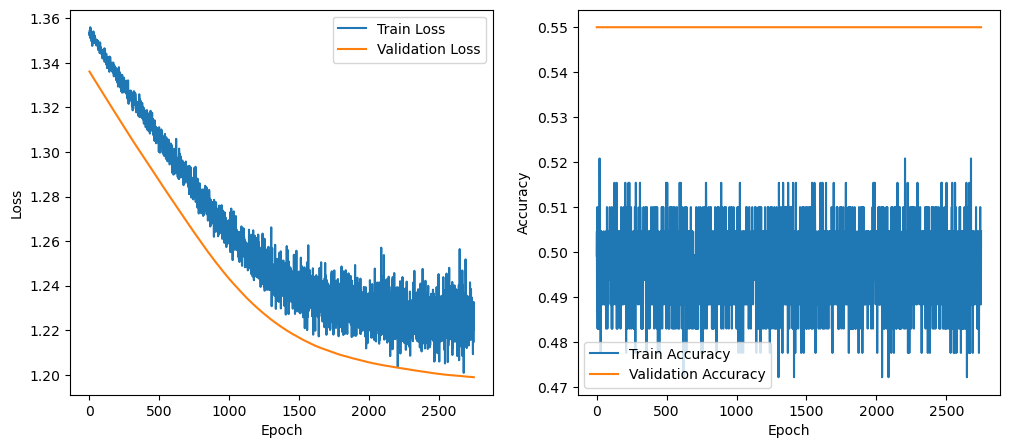

In [9]:
# Defining the model, optimizer and loss function
lr=0.00001
hidden_channels=32
num_layers=3
dropout=0.2
parameters = [lr, hidden_channels, num_layers, dropout]

model = MPNN(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
criterion = torch.nn.CrossEntropyLoss()

# Printing the model architecture
print(model)

# Running the training
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=2750)

Epoch 1/1500
Train Loss: 1.3703, Validation Loss: 1.3598
Train Accuracy: 0.1690, Validation Accuracy: 0.3000
Epoch 2/1500
Train Loss: 1.3725, Validation Loss: 1.3597
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 3/1500
Train Loss: 1.3711, Validation Loss: 1.3595
Train Accuracy: 0.1528, Validation Accuracy: 0.3000
Epoch 4/1500
Train Loss: 1.3706, Validation Loss: 1.3594
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 5/1500
Train Loss: 1.3705, Validation Loss: 1.3592
Train Accuracy: 0.1690, Validation Accuracy: 0.3000
Epoch 6/1500
Train Loss: 1.3706, Validation Loss: 1.3591
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 7/1500
Train Loss: 1.3693, Validation Loss: 1.3589
Train Accuracy: 0.1744, Validation Accuracy: 0.3000
Epoch 8/1500
Train Loss: 1.3696, Validation Loss: 1.3587
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 9/1500
Train Loss: 1.3697, Validation Loss: 1.3585
Train Accuracy: 0.1744, Validation Accuracy: 0.3000
Epoch 10/1500
Train

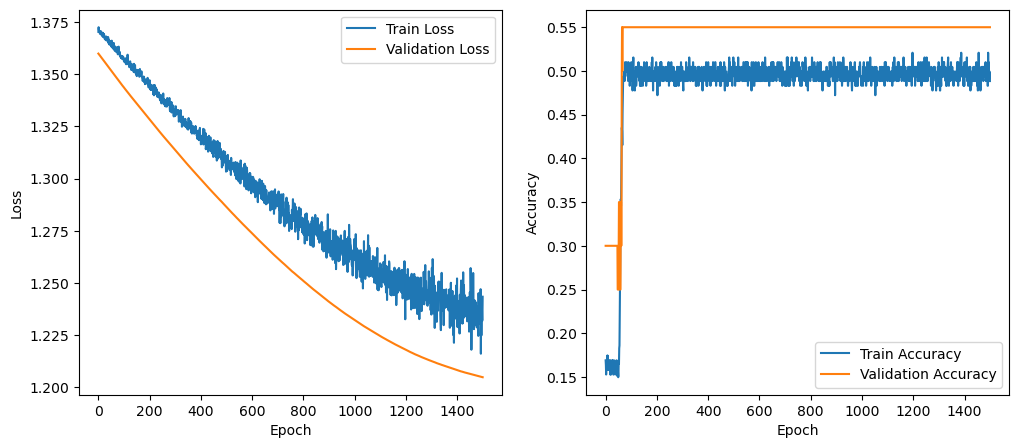

Epoch 1/1500
Train Loss: 1.4207, Validation Loss: 1.4388
Train Accuracy: 0.1042, Validation Accuracy: 0.0500
Epoch 2/1500
Train Loss: 1.4196, Validation Loss: 1.4387
Train Accuracy: 0.1150, Validation Accuracy: 0.0500
Epoch 3/1500
Train Loss: 1.4192, Validation Loss: 1.4385
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 4/1500
Train Loss: 1.4191, Validation Loss: 1.4383
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 5/1500
Train Loss: 1.4202, Validation Loss: 1.4382
Train Accuracy: 0.1042, Validation Accuracy: 0.0500
Epoch 6/1500
Train Loss: 1.4195, Validation Loss: 1.4380
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 7/1500
Train Loss: 1.4190, Validation Loss: 1.4379
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 8/1500
Train Loss: 1.4184, Validation Loss: 1.4377
Train Accuracy: 0.1150, Validation Accuracy: 0.0500
Epoch 9/1500
Train Loss: 1.4177, Validation Loss: 1.4376
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 10/1500
Train

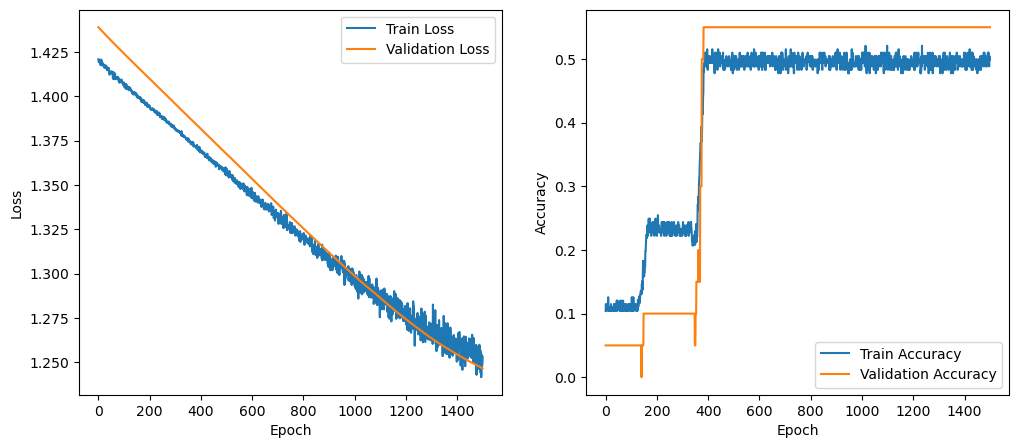

Epoch 1/1500
Train Loss: 1.3709, Validation Loss: 1.3463
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 2/1500
Train Loss: 1.3713, Validation Loss: 1.3462
Train Accuracy: 0.1528, Validation Accuracy: 0.3000
Epoch 3/1500
Train Loss: 1.3713, Validation Loss: 1.3461
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 4/1500
Train Loss: 1.3719, Validation Loss: 1.3460
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 5/1500
Train Loss: 1.3708, Validation Loss: 1.3459
Train Accuracy: 0.1744, Validation Accuracy: 0.3000
Epoch 6/1500
Train Loss: 1.3714, Validation Loss: 1.3458
Train Accuracy: 0.1528, Validation Accuracy: 0.3000
Epoch 7/1500
Train Loss: 1.3721, Validation Loss: 1.3456
Train Accuracy: 0.1690, Validation Accuracy: 0.3000
Epoch 8/1500
Train Loss: 1.3721, Validation Loss: 1.3455
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 9/1500
Train Loss: 1.3712, Validation Loss: 1.3454
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 10/1500
Train

KeyboardInterrupt: 

In [ ]:
# Doing some parameter gridsearch to find the best hyperparameters
from sklearn.model_selection import ParameterGrid

MP = True

# param_grid = {
#     'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
#     'hidden_channels': [128, 64, 32],
#     'num_layers': [3, 2, 1],
#     'dropout_rate': [0.3, 0.2, 0.1, 0.0]
# }
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01],
    'hidden_channels': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3]
}

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 2750
# Train using each combination
for params in param_combinations:
    if MP:
        filename = f'MPNN_Models_MP/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}.png'
    else:
        filename = f'MPNN_Models/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
        model = MPNN(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
        criterion = torch.nn.CrossEntropyLoss()
        train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=2750)